# Lab 6: Deep Learning with TensorFlow
**Using the Keras API**

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import tensorflow.keras as keras

## Running example
We use the Fashion-MNIST dataset, which consists of 28x28 pixel images of 10 classes of fashion items.

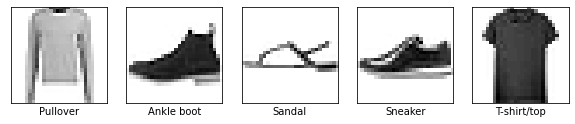

In [2]:
# Download FMINST data. Takes a while the first time.
mnist = oml.datasets.get_dataset(40996)
X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array');
X = X.reshape(70000, 28, 28)
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

# Take some random examples
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X[n], cmap=plt.cm.gray_r)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("{}".format(fmnist_classes[y[n]]))
plt.show();

In [3]:
X.shape

(70000, 28, 28)

### Preprocessing
#### Reshaping
To be able to feed this data through the network, the shape of the data must match the shape of the input layer.
For normal dense layers, this will be a 'flattened' array. You can use:
* [numpy.reshape()](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)
* [Keras reshaping layers](https://keras.io/api/layers/reshaping_layers/), e.g. [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/)
    * Can also be used to flatten the data at the *output* of the network


In [4]:
X = X.reshape((70000, 28 * 28))

#### Rescaling
Rescaling the data will help training a lot, and lead to faster convergence.
You can use min-max scaling to [0,1] or standardization (mean 0, standard deviation 1).
Note: We're using a simple division by the maximum possible value. This won't cause data leakage.

In [5]:
X = X.astype('float32') / 255

#### Label formatting
For multi-class classification, our output layer will usually have one output node per class. Therefore, we need to on-hot-encode the labels. E.g. class '4' becomes [0,0,0,0,1,0,...]
* Keras has a helper function [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) to do this

In [6]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

In [7]:
X.shape, y.shape

((70000, 784), (70000, 10))

### Train-test splits
Usually, simple hold-outs are used. This is valid if the datasets are large enough, and you take into account the usual concerns, such as stratification and grouping. For smaller datasets, you can use cross-validation as well, but you may get high variance in the per-fold results as neural networks may not always converge.

In [8]:
# For Fashion MNIST, there exists a predefined stratified train-test split of 60000-10000. We therefore don't shuffle or stratify here.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, random_state=0)

We can further split the training set into a training and validation set

In [9]:
Xf_train, x_val, yf_train, y_val = train_test_split(X_train, y_train, train_size=50000, shuffle=True, stratify=y_train, random_state=0)

### Building Sequential networks
* [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) models are the simplest kind of neural nets. They consist of a series of layers, one after the other.
* There exist [many types of layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers)
* For now, we'll only use [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) (fully-connected) layers. It has several important settings:
    * units: the number of nodes
    * activation: the [activation function](https://www.tensorflow.org/api_docs/python/tf/keras/activations) to use
    * kernel_initializer: how to [initialize the weights](https://www.tensorflow.org/api_docs/python/tf/keras/initializers)
    * kernel_regularizer: whether to apply L1/L2 [regularization](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers)
    
``` python
tf.keras.layers.Dense(
    units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
    activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
    **kwargs
)
```

A simple network with one hidden layer looks like this:
* Sequential.add() adds a layer to the network
* You can also pass an array of layers to the constructor: 'Sequential([layers])'
* We use ReLU activation for the hidden layer and SoftMax for the output layer.

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax'))

Metal device set to: Apple M1 Pro


2022-02-02 16:14:21.042917: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-02 16:14:21.043031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### The input layer
Note that the input layer can be defined by 'input_shape'. Alternatively, you could also add an explicit input layer.
In this case, the data is a flattened array of 28*28 inputs.

In [11]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(28 * 28,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

#### Activation layers

You can specify most activation functions, initializers, and regularizers as keyword strings.
If you need more control, you can specify the activation as an activation layer. The Dense layer will then use a linear activation, and the next layers applied your preferred activation.

In [12]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(28 * 28,)))
model.add(layers.Dense(512))
model.add(layers.ReLU(negative_slope=0.1)) # A leaky ReLU
model.add(layers.Dense(10, activation='softmax'))

#### Model summary
- 'model.summary()' prints a layer-wise summary of the model
    - hidden layer 1 : (28 * 28 + 1) * 512 = 401920
    - hidden layer 2 : (512 + 1) * 512 = 262656
    - output layer: (512 + 1) * 10 = 5130

In [13]:
## Add one more hidden layer for better performance
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [14]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dense_8 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Choosing loss, optimizer, metrics

'model.compile()' specifies how the model should be trained, i.e. which loss function and optimizer to use and which evaluation metrics to report.

* __Loss function__ [See overview](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
    - Cross-entropy (log loss) for multi-class classification ($y_{true}$ is one-hot encoded)
    - Use binary crossentropy for binary problems (single output node) 
    - Use sparse categorical crossentropy if $y_{true}$ is label-encoded (1,2,3,...)
* __Optimizer__ [See overview](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
    - Any of the available optimizers. RMSprop usually works well.
* __Metrics__ [See overview](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)
    - To monitor performance during training and testing, e.g. accuracy

The defaults versions of all of these can be specified by keywords

In [15]:
# Shorthand
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

For more control, the actual functions can be passed.

In [16]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

# Detailed
model.compile(loss=CategoricalCrossentropy(label_smoothing=0.01),
              optimizer=RMSprop(learning_rate=0.001, momentum=0.0),
              metrics=[Accuracy()])

### Training (fitting)
The 'fit' function trains the network and returns a history of the training and validation loss and all metrics per epoch.

```python
network.fit(X_train, y_train, epochs=3, batch_size=64)
```

There are 2 important hyperparameters:
* Number of epochs: enough to allow convergence
    * Too much: model starts overfitting (or just wastes time)
    
    
* Batch size: small batches (e.g. 32, 64,... samples) often preferred
    * 'Noisy' training data makes overfitting less likely
        * Larger batches generalize less well ('generalization gap')
    * Requires less memory (especially in GPUs)
    * Large batches do speed up training, may converge in fewer epochs

#### Repeated fitting
Calling 'model.fit' multiple times does not recreate the model from scratch (like scikit-learn does), it just continues training with the stored weights. To train from scratch, e.g. with different hyperparameters, you need to recreate the model, e.g. by wrapping it as a create_model function.

In [17]:
def create_model():
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(28 * 28,)))
    model.add(layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

#### Tracking progress
Calling 'fit' will print out the progress for every epoch, and returns a 'history' object which all losses and evaluation metrics.

In [18]:
model = create_model()
history = model.fit(Xf_train, yf_train, epochs=3, batch_size=64);

Epoch 1/3


2022-02-02 16:14:21.314333: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-02 16:14:21.463989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 6s 8ms/step - loss: 0.5242 - accuracy: 0.8115
Epoch 2/3
782/782 [==============================] - 6s 8ms/step - loss: 0.3855 - accuracy: 0.8602
Epoch 3/3
782/782 [==============================] - 6s 8ms/step - loss: 0.3558 - accuracy: 0.8713


In [19]:
model.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential_4", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 784], "dtype": "float32", "sparse": false, "ragged": false, "name": "dense_9_input"}}, {"class_name": "Dense", "config": {"name": "dense_9", "trainable": true, "batch_input_shape": [null, 784], "dtype": "float32", "units": 512, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "HeNormal", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_10", "trainable": true, "dtype": "float32", "units": 512, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "HeNormal", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bia

You can also specify a validation set so that the validation loss and accuracy is also returned.
'verbose=0' will silence the output prints.

In [20]:
model = create_model()
history = model.fit(Xf_train, yf_train, epochs=3, batch_size=32, verbose=0,
                    validation_data=(x_val, y_val))

2022-02-02 16:14:40.304700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 16:14:51.524872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


The returned history contains evaluation data (loss and metrics) for every epoch

In [21]:
history.history

{'loss': [0.5196696519851685, 0.4197826385498047, 0.3965308368206024],
 'accuracy': [0.8141800761222839, 0.8545200824737549, 0.8647000789642334],
 'val_loss': [0.444828063249588, 0.45543763041496277, 0.4412410259246826],
 'val_accuracy': [0.8461000323295593, 0.8510000109672546, 0.8672000169754028]}

### Predictions and evaluations
We can now call `predict` to generate predictions, and `evaluate` the trained model on the entire test set

``` python
network.predict(X_test)
test_loss, test_acc = network.evaluate(X_test, y_test)
```

2022-02-02 16:15:18.614863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[1.71400239e-18 3.29640335e-22 6.66167177e-18 6.84634490e-19
 8.18418960e-20 1.10093026e-07 4.03666283e-16 9.59356839e-06
 3.37293778e-13 9.99990344e-01]


[]

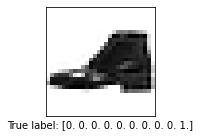

In [22]:
predictions = model.predict(X_test)

# Visualize one of the predictions
sample_id = 0
print(predictions[sample_id])

np.set_printoptions(precision=7)
fig, axes = plt.subplots(1, 1, figsize=(2, 2))
axes.imshow(X_test[sample_id].reshape(28, 28), cmap=plt.cm.gray_r)
axes.set_xlabel("True label: {}".format(y_test[sample_id]))
axes.set_xticks([])
axes.set_yticks([])

In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.4312 - accuracy: 0.8653
Test accuracy: 0.8653000593185425


## Checking the learning curve
There are several ways to check the learning curve
* Wait until the training is finished, then plot the results in the returned history
* Add a callback to the fit function that re-draws the learning curve in real time with every update
    * An example implementation is given below
* Use an external tool such as [TensorBoard](https://www.tensorflow.org/tensorboard/get_started)
* There are also commercial tools, e.g. [WeightsAndBiases](https://www.wandb.com/)

In [24]:
from IPython.display import clear_output

# For plotting the learning curve in real time
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.max_acc = 0
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.max_acc = max(self.max_acc, logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure(figsize=(8,3))
            plt.plot(N, self.losses, lw=2, c="b", linestyle="-", label = "train_loss")
            plt.plot(N, self.acc, lw=2, c="r", linestyle="-", label = "train_acc")
            plt.plot(N, self.val_losses, lw=2, c="b", linestyle=":", label = "val_loss")
            plt.plot(N, self.val_acc, lw=2, c="r", linestyle=":", label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}, Max Acc {:.4f}]".format(epoch, self.max_acc))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

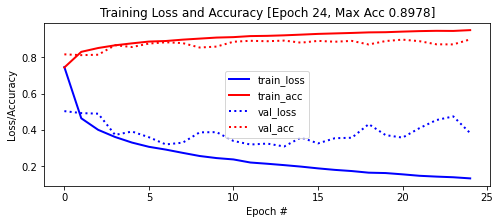

In [25]:
from sklearn.model_selection import train_test_split

plot_losses = TrainingPlot()
model = create_model()
history = model.fit(Xf_train, yf_train, epochs=25, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val), callbacks=[plot_losses])

### Early stopping
* Stop training when the validation loss (or validation accuracy) no longer improves
* Loss can be bumpy: use a moving average or wait for $k$ steps without improvement

``` python
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs=25, batch_size=512, callbacks=[earlystop])
```

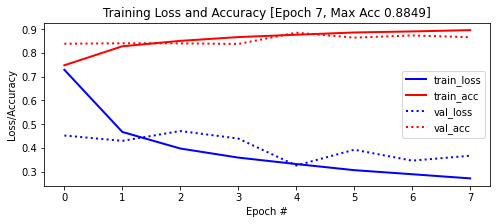

In [26]:
from tensorflow.keras import callbacks

earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=3)
model = create_model()
history = model.fit(Xf_train, yf_train, epochs=25, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop])

## Regularization
There are several ways that we can regularize our models it they are overfitting:
- Get more data
- Make the network smaller (e.g. use fewer nodes in the layers, or use fewer layers)
- Regularize the model weights (e.g. by L1/L2 regularization)
- Dropout
- Batch normalization also has a regularization effect

### Weight regularization (weight decay)
* Weight regularization can be applied to layers using a [kernel regularizer](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers)
- L1 regularization: leads to _sparse networks_ with many weights that are 0
- L2 regularization: leads to many very small weights

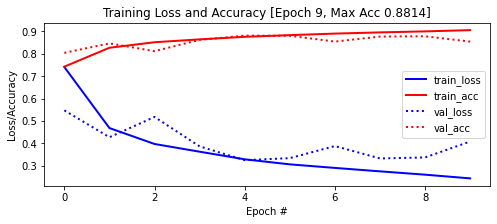

In [27]:
from tensorflow.keras import regularizers

earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5)
model = create_model()
history = model.fit(Xf_train, yf_train, epochs=50, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop])

### Dropout
* Dropout randomly sets a number of layer activations to 0. This avoids that non-significant patterns are 'memorized' by the model.
* It is added to the model via a [Dropout layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
* The _dropout rate_ (the fraction of the outputs that are zeroed-out) is usually between 0.1 and 0.5, but should be tuned to the specific network.
* You could add dropout after any dense layer.

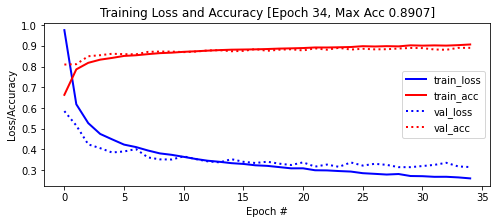

In [28]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = model.fit(Xf_train, yf_train, epochs=50, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop])

### Batch Normalization
* Batch normalization normalizes the activations of the previous layer within each batch
    * Within a batch, set the mean activation close to 0 and the standard deviation close to 1
        * Across badges, use exponential moving average of batch-wise mean and variance
    * Allows deeper networks less prone to vanishing or exploding gradients

```python

```


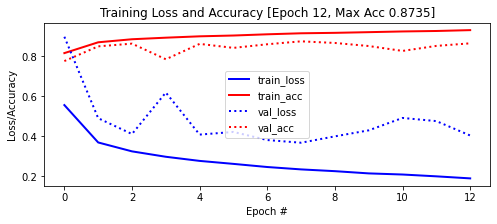

In [29]:
model = models.Sequential()
model.add(layers.Dense(265, activation='relu', input_shape=(28 * 28,)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = model.fit(Xf_train, yf_train, epochs=50, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop])

#### Combining multiple regularizers
There is some debate about whether it makes sense to combine multiple regularizers, and in which order. What works (or not) depends on the structure and size of the network and the dataset at hand. 

For instance, since Batch Normalization already does some regularization, Dropout may not be needed. However, in this case (see below), the combination does help. Sometimes it helps do use Dropout after Batch Normalization only in the deepest layers.

BatchNormalization is sometimes done before the Dense layer, but in general it works better if it is applied after the dense layer. Likewise, dropout can be applied before or after Batch Normalization. Using Dropout before Batch Normalization, however, will include 0's in the normalization statistics, which is not ideal.
[Here is an interesting paper on this topic](https://arxiv.org/pdf/1801.05134.pdf)

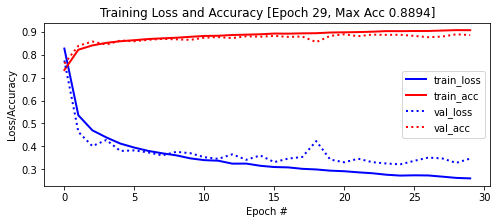

In [30]:
network = models.Sequential()
network.add(layers.Dense(265, activation='relu', input_shape=(28 * 28,)))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.3))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.3))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dropout(0.3))
network.add(layers.Dense(10, activation='softmax'))
network.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_losses = TrainingPlot()
history = network.fit(Xf_train, yf_train, epochs=50, batch_size=512, verbose=0,
                      validation_data=(x_val, y_val), callbacks=[plot_losses, earlystop])

### Tuning multiple hyperparameters
* Keras has an associated tuning library, [keras-tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner), with several tuning techniques:
- RandomSearch
- Hyperband
- BayesianOptimization
- Sklearn (for tuning scikit-learn models)

We'll cover Hyperband and Bayesian Optimization later.

Note: keras-tuner creates a folder with all results per 'project' (see the 'project_name' parameter).
You will need to remove the folder or change the project name to run it again.

In [31]:
!pip install -q -U keras-tuner

In [32]:
from tensorflow.keras import optimizers
import keras_tuner as kt


def build_model(hp):
    model = models.Sequential()

    # Tune the number of units in the dense layers
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 265, step = 32)

    model.add(keras.layers.Dense(units = hp_units, activation = 'relu', input_shape=(28 * 28,)))
    model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
    model.add(keras.layers.Dense(10))

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

    model.compile(optimizer = optimizers.Adam(learning_rate = hp_learning_rate),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

tuner = kt.RandomSearch(build_model, max_trials=5, objective = 'val_accuracy', project_name='lab7')

INFO:tensorflow:Reloading Oracle from existing project ./lab7/oracle.json
INFO:tensorflow:Reloading Tuner from ./lab7/tuner0.json


In [33]:
# Uncomment to run. It takes a while.
# tuner.search(Xf_train, yf_train, epochs = 10, validation_data = (x_val, y_val), callbacks = [TrainingPlot()])

# Get the optimal hyperparameters
#best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

* You can wrap Keras models as scikit-learn models using [KerasClassifier](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier) and use any tuning technique

In [34]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def build_model(var_activation='relu',var_optimizer='adam'):
    """ Uses arguments to build Keras model. """
    model = models.Sequential()
    model.add(layers.Dense(64,activation=var_activation, input_shape=(28 * 28,)))
    model.add(layers.Dense(32,activation=var_activation))
    model.add(layers.Dense(16,activation=var_activation))
    model.add(layers.Dense(10,activation='softmax'))
    model.compile(loss="categorical_crossentropy",
                optimizer=var_optimizer,
                metrics=["accuracy"])
    return model

# Search space
_activations=['tanh','relu','selu']
_optimizers=['sgd','adam']
_batch_size=[16,32,64]
params=dict(var_activation=_activations,
            var_optimizer=_optimizers,
            batch_size=_batch_size)

# Wrap
model = KerasClassifier(build_fn=build_model,epochs=4,batch_size=16)

/var/folders/0t/5d8ttqzd773fy0wq3h5db0xr0000gn/T/ipykernel_63314/5830362.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=build_model,epochs=4,batch_size=16)


In [35]:
from sklearn.model_selection import RandomizedSearchCV

# Uncomment to run. It takes a while.
#rscv = RandomizedSearchCV(model, param_distributions=params, cv=3, n_iter=10, verbose=1, n_jobs=-1)
#rscv_results = rscv.fit(Xf_train,yf_train)

In [37]:
#print('Best score is: {} using {}'.format(rscv_results.best_score_, rscv_results.best_params_))

### Further reading

https://www.tensorflow.org/learn

http://playground.tensorflow.org

https://www.tensorflow.org/tensorboard